In [14]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

In [2]:
def to_dec(x):
    return int("".join(str(i) for i in x), 2) 

def mixing_hamiltonian(c, qubits, par):
    for i in range(len(qubits)):
        c += cirq.rx(2 * par).on(qubits[i])
    return c

def cost_hamiltonian(c, qubits, g, ps):
    for edge in g.edges():
        c += cirq.CNOT(qubits[edge[0]], qubits[edge[1]])
        c += cirq.rz(ps).on(qubits[edge[1]])
        c += cirq.CNOT(qubits[edge[0]], qubits[edge[1]])
    return c

def cc(qubits, g):
    c = 0
    for edge in g.edges():
        c += cirq.PauliString(1/2 * cirq.Z(qubits[edge[0]]) * cirq.Z(qubits[edge[1]]))
    return c

def make_circuit(p, graph, qs):
    qaoa_circuit = cirq.Circuit()
    num_param = 2 * p 
    qaoa_parameters = sympy.symbols("q0:%d"%num_param)
    for i in qs:
        qaoa_circuit += cirq.H(i)
    for i in range(p):
        qaoa_circuit = cost_hamiltonian(qaoa_circuit, qs, graph, qaoa_parameters[2 * i])
        qaoa_circuit = mixing_hamiltonian(qaoa_circuit, qs, qaoa_parameters[2 * i + 1])
    return qaoa_circuit

def make_qaoa(graph, p, noise_level=None):
    qs = [cirq.GridQubit(0, i) for i in range(len(graph.nodes()))]
    qaoa_circuit = make_circuit(p, graph, qs)
    
    cost = cc(qs, graph)
    ins = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)
    if noise_level is not None:
        outs = tfq.layers.NoisyPQC(qaoa_circuit.with_noise(cirq.depolarize(p=noise_level)), cost, repetitions=1000, \
                                                  sample_based=False, differentiator=tfq.differentiators.ParameterShift())(ins)
    else:
        outs = tfq.layers.PQC(qaoa_circuit, cost, differentiator=tfq.differentiators.Adjoint())(ins)
    qaoa = tf.keras.models.Model(inputs=ins, outputs=outs)
    return qaoa

In [3]:
def train_qaoa(qaoa):
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    epoch = 0
    tol = 1e-4
    old = np.inf

    initial = cirq.Circuit()
    inputs = tfq.convert_to_tensor([initial])

    while epoch < 100:
        with tf.GradientTape() as tape:
            error = qaoa(inputs)
        
        grads = tape.gradient(error, qaoa.trainable_variables)
        opt.apply_gradients(zip(grads, qaoa.trainable_variables))
        error = error.numpy()[0][0]
        #if epoch % 10 == 0:
        #    print(epoch, error)
        if abs(old - error) < tol:
            break
        old = error
        epoch += 1
    
    return qaoa

In [4]:
def get_ratio(qaoa, graph, p, noise=None):
    if noise is not None:
        qaoa_circuit = make_circuit(p, graph, [cirq.GridQubit(0, i) \
                                               for i in range(len(graph.nodes()))]).with_noise(cirq.depolarize(p=noise_level))
        params = qaoa.trainable_variables
        num_param = 2 * p
        qaoa_parameters = sympy.symbols("q0:%d"%num_param)
        sample_circuit = tfq.layers.AddCircuit()(tfq.convert_to_tensor([cirq.Circuit()]), append=qaoa_circuit)
        output = tfq.layers.Sample('noisy')(sample_circuit, \
                                            symbol_names=qaoa_parameters, symbol_values=params, repetitions=1000)
    else:
        qaoa_circuit = make_circuit(p, graph, [cirq.GridQubit(0, i) for i in range(len(graph.nodes()))])
        params = qaoa.trainable_variables
        num_param = 2 * p
        qaoa_parameters = sympy.symbols("q0:%d"%num_param)
        sample_circuit = tfq.layers.AddCircuit()(tfq.convert_to_tensor([cirq.Circuit()]), append=qaoa_circuit)
        output = tfq.layers.Sample()(sample_circuit, symbol_names=qaoa_parameters, symbol_values=params, repetitions=1000)

    quantum_preds = []
    data = []
    for bits in output.values:
        temp = []
        data.append(to_dec(bits.numpy()))
        for pos, bit in enumerate(bits):
            if bit == 1:
                temp.append(pos)
        quantum_preds.append(temp)

    sub_lists = []
    for i in range(nodes + 1):
        temp = [list(x) for x in combinations(graph.nodes(), i)]
        sub_lists.extend(temp)

    cut_classic = []
    for sub_list in sub_lists:
        cut_classic.append(nx.algorithms.cuts.cut_size(graph, sub_list))

    cut_quantum = []
    for cut in quantum_preds:
        cut_quantum.append(nx.algorithms.cuts.cut_size(graph, cut))

    return np.mean(cut_quantum)/np.max(cut_classic)

In [ ]:
nodes = 5
training_size = 50
noiseless = []
noisy_train = []
noisy_train_eval = []
ps = [i for i in range(1, 21)]
noise_level = 0.01

for p in ps:
    ratios = []
    for i in range(training_size):
        if i % 20 == 0:
            print(p, i)
        g = nx.erdos_renyi_graph(n=nodes, p=0.5)
        qaoa = make_qaoa(g, p)
        results = train_qaoa(qaoa)
        ratios.append(get_ratio(results, g, p))
    
    noiseless.append(np.mean(ratios))  
    print(p noiseless[-1])
    
    ratios = []
    for i in range(training_size):
        if i % 20 == 0:
            print(p, i)
        g = nx.erdos_renyi_graph(n=nodes, p=0.5)
        qaoa = make_qaoa(g, p, noise_level)
        results = train_qaoa(qaoa)
        ratios.append(get_ratio(results, g, p))
    
    noisy_train.append(np.mean(ratios))
    print(p, noisy_train[-1])
    
    ratios = []
    for i in range(training_size):
        if i % 20 == 0:
            print(p, i)
        g = nx.erdos_renyi_graph(n=nodes, p=0.5)
        qaoa = make_qaoa(g, p, noise_level)
        results = train_qaoa(qaoa)
        ratios.append(get_ratio(results, g, p, noise_level))
    
    noisy_train_eval.append(np.mean(ratios))
    print(p, noisy_train_eval[-1])

    np.save("noiseless", np.array(noiseless))
    np.save("noisy_train", np.array(noisy_train))
    np.save("noisy_train_eval", np.array(noisy_train_eval))

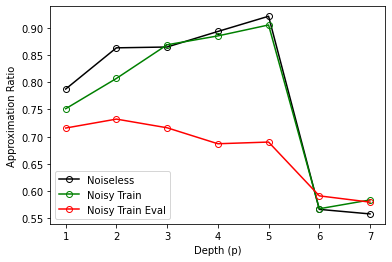

In [12]:
noiseless = np.load("noiseless.npy").tolist()
noisy_train = np.load("noisy_train.npy").tolist()
noisy_train_eval = np.load("noisy_train_eval.npy").tolist()
ps = [i + 1 for i in range(len(noiseless))]

plt.plot(ps, noiseless, marker='o', color='black', label='Noiseless', markerfacecolor='none')
plt.plot(ps, noisy_train, marker="o", color='green', label='Noisy Train', markerfacecolor='none')
plt.plot(ps, noisy_train_eval, marker="o", color='red', label='Noisy Train Eval', markerfacecolor='none')
plt.legend()
plt.xlabel("Depth (p)")
plt.ylabel("Approximation Ratio")
plt.show()

In [ ]:
ns = [4, 5, 6, 7, 8, 9, 10, 11]
training_size = 30
noiseless_p = []
noisy_train_p = []
noisy_train_eval_p = []
p = 4
noise_level = 0.01

for n in ns:
    ratios = []
    for i in range(training_size):
        if i % 20 == 0:
            print(p, i)
        g = nx.erdos_renyi_graph(n=n, p=0.5)
        qaoa = make_qaoa(g, p)
        results = train_qaoa(qaoa)
        ratios.append(get_ratio(results, g, p))
    
    noiseless_p.append(np.mean(ratios))  
    print(ps[p - 1], noiseless_p[-1])
    
    ratios = []
    for i in range(training_size):
        if i % 20 == 0:
            print(p, i)
        g = nx.erdos_renyi_graph(n=n, p=0.5)
        qaoa = make_qaoa(g, p, noise_level)
        results = train_qaoa(qaoa)
        ratios.append(get_ratio(results, g, p))
    
    noisy_train_p.append(np.mean(ratios))
    print(ps[p - 1], noisy_train_p[-1])
    
    ratios = []
    for i in range(training_size):
        if i % 20 == 0:
            print(p, i)
        g = nx.erdos_renyi_graph(n=n, p=0.5)
        qaoa = make_qaoa(g, p, noise_level)
        results = train_qaoa(qaoa)
        ratios.append(get_ratio(results, g, p, noise_level))
    
    noisy_train_eval_p.append(np.mean(ratios))
    print(ps[p - 1], noisy_train_eval_p[-1])

    np.save("noiseless_p", np.array(noiseless_p))
    np.save("noisy_train_p", np.array(noisy_train_p))
    np.save("noisy_train_eval_p", np.array(noisy_train_eval_p))

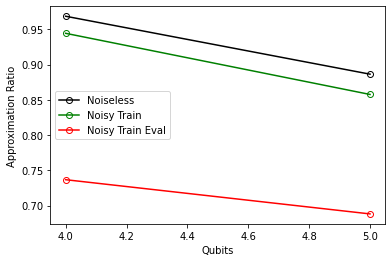

In [15]:
noiseless_p = np.load("noiseless_p.npy").tolist()
noisy_train_p = np.load("noisy_train_p.npy").tolist()
noisy_train_eval_p = np.load("noisy_train_eval_p.npy").tolist()
ns = [i + 4 for i in range(len(noiseless_p))]

plt.plot(ns, noiseless_p, marker='o', color='black', label='Noiseless', markerfacecolor='none')
plt.plot(ns, noisy_train_p, marker="o", color='green', label='Noisy Train', markerfacecolor='none')
plt.plot(ns, noisy_train_eval_p, marker="o", color='red', label='Noisy Train Eval', markerfacecolor='none')
plt.legend()
plt.xlabel("Qubits")
plt.ylabel("Approximation Ratio")
plt.show()